# Check GPU

In [17]:
import torch

gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU Name: {gpu_name}")

GPU Available: True
GPU Name: NVIDIA H100


# Load datasets

In [1]:
from datasets import load_dataset
import os

data_path = "../data/elaborations"

data_files_c2s = {
    'train': os.path.join(data_path,"train","train_ds_c2s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2s.csv")         
}

data_files_c4s = {
    'train': os.path.join(data_path,"train","train_ds_c4s.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4s.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4s.csv")         
}

data_files_c2sp = {
    'train': os.path.join(data_path,"train","train_ds_c2sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c2sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c2sp.csv")         
}

data_files_c4sp = {
    'train': os.path.join(data_path,"train","train_ds_c4sp.csv"),      
    'validation': os.path.join(data_path,"validation","valid_ds_c4sp.csv"),  
    'test': os.path.join(data_path,"test","test_ds_c4sp.csv")         
}

dataset = load_dataset('csv', data_files=data_files_c4sp)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 1049
    })
    validation: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 134
    })
    test: Dataset({
        features: ['doc_num', 'source_text', 'label_text', 'elaboration_sentence', 'contextual_specificity_rating'],
        num_rows: 116
    })
})


## Check texts length

In [2]:
def count_texts_over_word_limit(dataset_dict, column, word_limit=512):
    word_count = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        count_over_limit = 0

        for example in dataset:
            try:
                num_words = len(example[column].split()) # count on spaces
                if num_words > word_limit:
                    count_over_limit += 1
            except AttributeError as e: 
                print(f"Empty string in doc num: {example['doc_num']}")
                continue 

        word_count[split] = count_over_limit

    return word_count

In [15]:
print("Model's max length: ", tokenizer.model_max_length)

Model's max length:  1024


In [4]:
count_texts_over_word_limit(dataset, column='label_text', word_limit=150)

{'train': 0, 'validation': 0, 'test': 0}

In [5]:
count_texts_over_word_limit(dataset, column='source_text', word_limit=150)

{'train': 0, 'validation': 0, 'test': 0}

# Load the model

In [6]:
from transformers import BartTokenizerFast, BartForConditionalGeneration, BartTokenizer
import torch

tokenizer = BartTokenizer.from_pretrained('facebook/bart-base',use_fast=False) 
model = BartForConditionalGeneration.from_pretrained('facebook/bart-base', device_map ={'':torch.cuda.current_device()})

#tokenizer = BartTokenizer.from_pretrained('facebook/bart-large',use_fast=False) 
#model = BartForConditionalGeneration.from_pretrained('facebook/bart-large', device_map ={'':torch.cuda.current_device()})

## Tokenize datasets

In [7]:
def calculate_average_token_length(dataset_dict, column):
    token_lengths = {}

    for split in dataset_dict:
        dataset = dataset_dict[split]
        total_tokens = 0
        num_texts = 0

        for example in dataset:
            try:
                # Tokenize the text and count the number of tokens
                tokens = tokenizer(example[column], truncation=False, padding=False)['input_ids']
                total_tokens += len(tokens)
                num_texts += 1
            except (AttributeError, KeyError) as e:
                print(f"Error processing text in split '{split}', doc num: {example.get('doc_num', 'unknown')}")
                continue

        # Calculate the average token length for the split
        if num_texts > 0:
            average_length = total_tokens / num_texts
        else:
            average_length = 0  # Set to 0 if no valid texts

        token_lengths[split] = average_length

    return token_lengths

average_token_lengths = calculate_average_token_length(dataset, column="source_text")
average_label_lengths = calculate_average_token_length(dataset, column="elaboration_sentence")
print("Average token lengths per split:", average_token_lengths)
print("Average label lengths per split:", average_label_lengths)

Average token lengths per split: {'train': 99.74928503336511, 'validation': 99.44029850746269, 'test': 99.5}
Average label lengths per split: {'train': 12.938036224976168, 'validation': 13.26865671641791, 'test': 13.112068965517242}


In [8]:
def tokenize_func(examples):
    # inputs
    inputs = tokenizer(examples['source_text'], truncation=True, padding="max_length", max_length=150)
    # labels
    labels = tokenizer(examples['elaboration_sentence'],truncation=True, padding="max_length", max_length=150)
    # set the labels in the input dictionary
    inputs['labels'] = labels['input_ids']
    return inputs

In [9]:
tokenized_dataset = dataset.map(tokenize_func, batched=True)
tokenized_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Set up model's configuration

In [10]:
from transformers import GenerationConfig

generation_config = GenerationConfig(
    bos_token_id = 0,
    decoder_start_token_id = 2,
    early_stopping = True,
    max_new_tokens = 32, # 512
    eos_token_id = 2, 
    forced_bos_token_id = 0,
    forced_eos_token_id = 2,
    no_repeat_ngram_size = 3,
    num_beams = 4,
    pad_token_id = 1
)

model.config.update(generation_config.to_dict())

## Dropout

In [6]:
model.config.dropout = 0.2
print(model.config.dropout)

0.2


## Tokenizer

In [ ]:
from transformers import AddedToken

special_tokens_dict = {
    'bos_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'eos_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'unk_token': AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'sep_token': AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'pad_token': AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'cls_token': AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
    'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True)
}

# add the special tokens to the tokenizer
tokenizer.add_special_tokens(special_tokens_dict)

# Train the model

In [11]:
import os 
# disable parallelism warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [24]:
num_samples = len(dataset['train'])
batch_size= 6
logging_steps = 25
print("Steps per epoch: ", num_samples//batch_size )
print("Logging steps: " ,num_samples//batch_size//logging_steps )

Steps per epoch:  174
Logging steps:  6


## Seq2Seq

In [12]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments, EarlyStoppingCallback
import numpy as np
from easse.sari import corpus_sari
from sacrebleu.tokenizers.tokenizer_13a import Tokenizer13a
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def compute_sari(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # source texts 
    sources = tokenized_dataset['validation']['source_text']

    # SARI scores
    sari_scores = []
    for pred, label, source in zip(decoded_preds, decoded_labels, sources):
        sari_score = corpus_sari(
            orig_sents=[source],  # original source sentence
            sys_sents=[pred],     # system's generated sentence
            refs_sents=[[label]]  # reference simplified sentence
        )
        sari_scores.append(sari_score)
    
    # average SARI score across all examples
    avg_sari = np.mean(sari_scores)
    return {"sari": avg_sari}

# 13a tokenizer
#tokenizer13a = Tokenizer13a()
#smoothing_function = SmoothingFunction().method1

def compute_bleu(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    print(decoded_preds)
    print(decoded_labels)

    all_refs = []
    all_preds = []
    for pred, ref in zip(decoded_preds, decoded_labels):
        tokenized_ref = tokenizer13a(ref).split()
        tokenized_pred = tokenizer13a(pred).split()
        all_refs.append([tokenized_ref]) 
        all_preds.append(tokenized_pred)

    bleu_score_1 = corpus_bleu(all_refs, all_preds, weights=(1.0, 0, 0, 0), smoothing_function=smoothing_function)  # 1-gram
    bleu_score_2 = corpus_bleu(all_refs, all_preds, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)  # 2-gram
    return {"BLEU-1": bleu_score_1, "BLEU-2":  bleu_score_2}

model.train()

training_args = Seq2SeqTrainingArguments(
    output_dir="../models/bart-news-ft/results/results-news-bart-base-c4sp-elab-sent-target",
    eval_strategy="epoch",
    save_strategy = "epoch",
    logging_strategy="steps",
    logging_steps=25,
    learning_rate=1e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2, 
    num_train_epochs=3,
    save_total_limit=3,
    weight_decay=0.01,
    warmup_steps = 2,
    #gradient_accumulation_steps=2,
    optim = "paged_adamw_8bit",
    load_best_model_at_end=True,
    fp16=True,
    logging_dir="../models/bart-news-ft/logs/logs-news-bart-base-c4sp-elab-sent-target",
    predict_with_generate=True,
    metric_for_best_model='loss'
)


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    #compute_metrics=compute_bleu,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.297100,0.262311
2,0.185300,0.260044
3,0.102600,0.282234


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the generation config model attribute before calling the model's `save_pretrained`, preferably also removing any generation kwargs from the model config. This warni

TrainOutput(global_step=1575, training_loss=0.3643733487053523, metrics={'train_runtime': 69.1245, 'train_samples_per_second': 45.527, 'train_steps_per_second': 22.785, 'total_flos': 281080171008000.0, 'train_loss': 0.3643733487053523, 'epoch': 3.0})

## Trainer

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from easse.sari import corpus_sari
from tqdm.notebook import tqdm

def compute_sari(pred):
    
    predictions = pred.predictions
    labels = pred.label_ids
    
    # decode the predictions and labels into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # source texts 
    sources = tokenized_dataset['validation']['r_content']

    # SARI scores
    sari_scores = []
    for pred, label, source in tqdm(zip(decoded_preds, decoded_labels, sources)):
        sari_score = corpus_sari(
            orig_sents=[source],  # original source sentence
            sys_sents=[pred],     # system's generated sentence
            refs_sents=[[label]]  # reference simplified sentence
        )
        sari_scores.append(sari_score)
    
    # average SARI score across all examples
    avg_sari = np.mean(sari_scores)
    return {"sari": avg_sari}

model.train()

training_args = TrainingArguments(
    output_dir="../models/bart-news-ft/results/results-news-bart-epoch10-lr1-trainer",
    eval_strategy="epoch", 
    save_strategy = "epoch", 
    logging_strategy="steps",
    logging_steps=25,
    learning_rate=1e-5, 
    per_device_train_batch_size=6, 
    per_device_eval_batch_size=6, 
    num_train_epochs=10, 
    weight_decay=0.01,
    save_total_limit=3, 
    #gradient_accumulation_steps=6, # reduce memory
    load_best_model_at_end=True, # based on valid loss
    metric_for_best_model='loss',
    warmup_steps = 2,
    optim = "paged_adamw_8bit", # optimizer for quantization
    fp16=True, # enable half-precision
    logging_dir="../models/bart-news-ft/logs/logs-news-bart-epoch10-lr1-trainer",
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_sari,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

model.config.use_cache = False

In [ ]:
trainer.train()

## Training Process

In [9]:
log_history = trainer.state.log_history
eval_logs = [log for log in log_history if "eval_loss" in log]

# the best (lowest) validation loss
best_eval_log = min(eval_logs, key=lambda x: x["eval_loss"])

print(f"Best validation loss: {best_eval_log['eval_loss']}")
print(f"Epoch of the best model: {best_eval_log['epoch']}")
#print("Sari score: ", best_eval_log['eval_sari'] )

Best validation loss: 0.6219741702079773
Epoch of the best model: 1.0


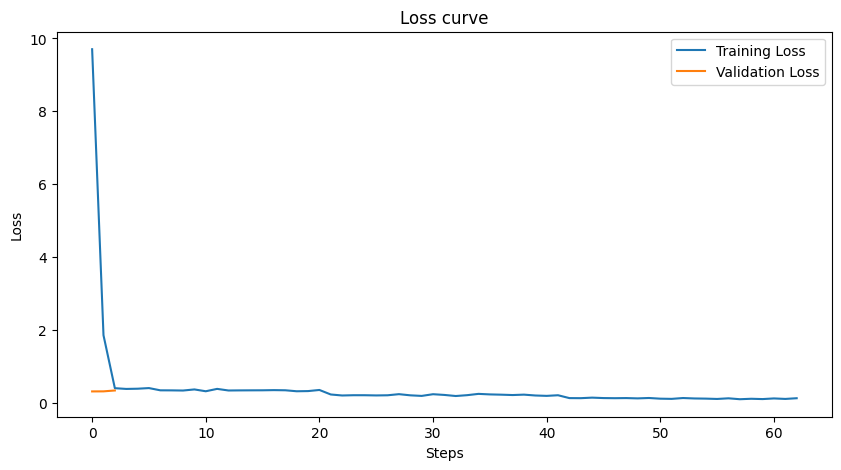

In [15]:
import matplotlib.pyplot as plt

# loss values from the log history
train_loss = [log['loss'] for log in trainer.state.log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in trainer.state.log_history if 'eval_loss' in log]
steps = range(len(train_loss))

plt.figure(figsize=(10,5))
plt.plot(steps, train_loss, label='Training Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Loss curve')
plt.legend()
plt.show()

# Save model

In [22]:
generation_config.save_pretrained("../models/bart-news-ft/model-2csp")
#tokenizer.save_pretrained("../models/bart-swipe-ft/model-swipe-clean")
model.save_pretrained("../models/bart-news-ft/model-2csp")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


# Load the saved model

In [1]:
from transformers import BartForConditionalGeneration, BartTokenizer, GenerationConfig


model_path = "../models/bart-news-short-ft/model-news-short-bart-tokenizer"

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large', use_fast=False)
model = BartForConditionalGeneration.from_pretrained(model_path)
generation_config = GenerationConfig.from_pretrained(model_path)
model.generation_config = generation_config

# Generate predictions

In [14]:
torch.cuda.empty_cache()

In [14]:
from tqdm import tqdm
import torch

predictions = []

model.eval()
model.config.use_cache = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

with torch.no_grad():
    for example in tqdm(dataset['test']):
        # tokenize the text
        input_ids = tokenizer(example['source_text'], return_tensors="pt")
        # move input_ids to the same device as the model
        input_ids = {key: value.to(device) for key, value in input_ids.items()}
        
        # generate prediction
        output_ids = model.generate(**input_ids, do_sample=False, num_return_sequences=1) # temperature=0.45, do_sample=True
        simplified_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
        
        predictions.append(simplified_text)

  0%|                                                   | 0/116 [00:00<?, ?it/s]/home/6/ud03926/nlp/lib64/python3.9/site-packages/transformers/generation/utils.py:1364: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
100%|█████████████████████████████████████████| 116/116 [00:07<00:00, 14.52it/s]


In [14]:
from tqdm.notebook import tqdm
from easse.sari import corpus_sari


sari_scores_easse = []

for index, row in tqdm(enumerate(dataset["test"]), total=len(dataset["test"])):
    r_content = row['source_text'] 
    s_content = row['label_text']
    prediction = predictions[index] 
    
    sari_score_easse = corpus_sari(
        orig_sents=[r_content],
        sys_sents=[prediction],
        refs_sents=[[s_content]]
    )
    
    sari_scores_easse.append(sari_score_easse)

  0%|          | 0/116 [00:00<?, ?it/s]

In [15]:
import numpy as np
print("Average SARI score:", np.mean(sari_scores_easse))

Average SARI score: 5.227781836125757


## BLEU scores

In [16]:
from tqdm.notebook import tqdm
from easse.bleu import corpus_bleu


bleu_scores_easse = []

for index, row in tqdm(enumerate(dataset["test"]), total=len(dataset["test"])):
    s_content = row['label_text']
    prediction = predictions[index] 
    
    bleu_score_easse = corpus_bleu(
        sys_sents=[prediction],
        refs_sents=[[s_content]]
    )
    
    bleu_scores_easse.append(bleu_score_easse)

  0%|          | 0/116 [00:00<?, ?it/s]

In [17]:
import numpy as np
print("Average SARI score:", np.mean(sari_scores_easse))
print("Average BLEU score:", np.mean(bleu_scores_easse))

Average SARI score: 37.00045679144054
Average BLEU score: 84.0330736387988


## Save generation results

In [15]:
import pandas as pd

df_results = pd.DataFrame({
    'source_text': dataset['test']['source_text'], 
    'elaboration_sentence': dataset['test']['elaboration_sentence'],
    'prediction': predictions
})

df_results.head()

,source_text,elaboration_sentence,prediction
0,They did not need special skills or a college ...,Many do not have the money to get the training...,They do not have the skills to go to college.
1,WASHINGTON – At least four people died in Midw...,A gauge is a kind of measuring stick.,The gauges are meant to track water.
2,WASHINGTON – At least four people died in Midw...,It sits in the water.,A gauge is a tube that moves water through the...
3,Rescue crews swarmed into the ruins at Plaza T...,They raced against the setting sun to search t...,The school was damaged by the tornado.
4,"One half of Istanbul lies in Europe, while the...",Turkey is larger than the state of Texas.,It is one of the largest cities in the world.


In [16]:
df_results.to_csv("../data/gen_predictions/predictions_bart-base-c4sp-elab-sent-target-greedy.csv", index=False)